In [1]:
DATA_DIR = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/data/'
GRAPH_PATH = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/graph/'
SAMPLE_SIZE = 100_000
GSV_SAMPLE_SIZE = 1000
window = 60000
shift = 10000
features = ['API_SESSION', 'API_TOKEN', 'AUTH_CODE',
            'EMAIL', 'JSESSION_ID', 'LOGIN', 'MESSENGER', 'PHONE',
            'SOCIAL_API_TOKEN', 'TWO_FACTOR', 'USER_ID_TYPE',
            'USER_ID_NO_PASSWORD']
batch_window = 43_200_000
train_frac = 0.5

In [2]:
!pip install pyarrow
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import user_agents
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion


from random import *

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
columns=['USER_ID', 'TIMESTAMP', 'LOGIN_CREDENTIAL_TYPE']
botsLogins = pq.read_table(DATA_DIR + 'botsLogins.parquet', columns=columns).to_pandas().head(SAMPLE_SIZE >> 1)
usersLogins = pq.read_table(DATA_DIR + 'usersLogins.parquet', columns=columns).to_pandas().head(SAMPLE_SIZE >> 1)

In [4]:
botsLogins['isBot'] = 1
usersLogins['isBot'] = 0
logins = botsLogins.append(usersLogins)

In [5]:
def time_preprocessing(table, window, shift, ts_min):
    nshift = int(window / shift)
    window_count = pd.DataFrame()
    for i in range(0, int(window / shift)):
        ts_i_col = "TS_PART_".format(i)
        table[ts_i_col] = table.apply(lambda x: int((x.name - ts_min + i * shift) / window) * nshift + i, axis=1)
        ts_part_cred_count = table.groupby([ts_i_col,'USER_ID', 'isBot', 'LOGIN_CREDENTIAL_TYPE']).size().unstack(fill_value=0)
        ts_part_cred_count.rename(index=str, columns={"USER_ID": "USER_ID_TYPE", ts_i_col : "TS_PART"}, inplace=True)
        ts_part_cred_count.reset_index(inplace=True)
        window_count = window_count.append(ts_part_cred_count)
    return window_count

def feature_preprocessing(window_count, features):
    X = window_count.reindex(columns=features, fill_value=0)
    y = window_count['isBot'].astype('int64')
    return X, y

In [6]:
logins.sort_values(by=['TIMESTAMP'], inplace=True)
ts_min = logins['TIMESTAMP'].min()
ts_max = logins['TIMESTAMP'].max()
logins.set_index('TIMESTAMP', inplace=True)

In [7]:
logins_gscv = logins.sample(n=GSV_SAMPLE_SIZE, random_state=17)
window_count = time_preprocessing(logins_gscv, window, shift, ts_min)
X, y = feature_preprocessing(window_count, features)
parameters = {'alpha': (0.1, 0.01, 0.001, 0.00001, 0.0000001),
              #'penalty': ('l1', 'l2', 'elasticnet'),
              'max_iter': (5, 10, 50, 80, 500, 1000),}
clf = SGDClassifier(random_state=17)                                                  
grid_search = GridSearchCV(clf, parameters, n_jobs=1, verbose=1, cv=5)
grid_search.fit(X, y)
print(grid_search.best_params_, grid_search.best_score_)
alpha = grid_search.best_params_['alpha']
# penalty = grid_search.best_params_['penalty']
penalty = 'l2'
max_iter = grid_search.best_params_['max_iter']

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'alpha': 0.001, 'max_iter': 5} 0.8686058174523571


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   12.2s finished


In [8]:
train_test_split_bound = int(logins.shape[0] * train_frac)
train_logins = logins[:train_test_split_bound]
test_logins = logins[train_test_split_bound:]

In [9]:
pd.options.mode.chained_assignment = None
clf = SGDClassifier(random_state=17, max_iter=max_iter, alpha=alpha, penalty=penalty)
for i in range(ts_min, ts_max - batch_window, batch_window):
    batch = train_logins.loc[i:i + batch_window]
    if (batch.shape[0] == 0):
        continue
    print("Batch", i, i + batch_window)
    window_count = time_preprocessing(batch, window, shift, ts_min)
    X_batch, y_batch = feature_preprocessing(window_count, features)
    clf.partial_fit(X_batch, y_batch, classes=[0,1])

Batch 1517432439623 1517475639623
Batch 1517475639623 1517518839623
Batch 1517518839623 1517562039623
Batch 1517562039623 1517605239623
Batch 1517605239623 1517648439623
Batch 1517648439623 1517691639623
Batch 1517691639623 1517734839623
Batch 1517734839623 1517778039623
Batch 1517778039623 1517821239623
Batch 1517821239623 1517864439623
Batch 1517864439623 1517907639623
Batch 1517907639623 1517950839623
Batch 1517950839623 1517994039623
Batch 1517994039623 1518037239623
Batch 1518037239623 1518080439623
Batch 1518080439623 1518123639623
Batch 1518123639623 1518166839623
Batch 1518166839623 1518210039623
Batch 1518210039623 1518253239623
Batch 1518253239623 1518296439623
Batch 1518296439623 1518339639623
Batch 1518339639623 1518382839623
Batch 1518382839623 1518426039623
Batch 1518426039623 1518469239623


In [10]:
def batch_predict_actual(clf, logins, verbose=False):
    predict = np.array([])
    actual = np.array([])
    for i in range(ts_min, ts_max - batch_window, batch_window):
        batch = logins.loc[i:i + batch_window]
        if (batch.shape[0] == 0):
            continue
        if (verbose):
            print("Batch", i, i + batch_window)
        window_count = time_preprocessing(batch, window, shift, ts_min)
        X_test_batch, y_test_batch = feature_preprocessing(window_count, features)
        predict = np.append(predict, clf.predict(X_test_batch))
        actual = np.append(actual, y_test_batch)
    return actual, predict

In [11]:
actual, predict = batch_predict_actual(clf, test_logins, verbose=True)
print(classification_report(actual, predict))

Batch 1518426039623 1518469239623
Batch 1518469239623 1518512439623
Batch 1518512439623 1518555639623
Batch 1518555639623 1518598839623
Batch 1518598839623 1518642039623
Batch 1518642039623 1518685239623
Batch 1518685239623 1518728439623
Batch 1518728439623 1518771639623
Batch 1518771639623 1518814839623
Batch 1518814839623 1518858039623
Batch 1518858039623 1518901239623
Batch 1518901239623 1518944439623
Batch 1518944439623 1518987639623
Batch 1518987639623 1519030839623
Batch 1519030839623 1519074039623
Batch 1519074039623 1519117239623
Batch 1519117239623 1519160439623
Batch 1519160439623 1519203639623
Batch 1519203639623 1519246839623
Batch 1519246839623 1519290039623
Batch 1519290039623 1519333239623
Batch 1519333239623 1519376439623
Batch 1519376439623 1519419639623
Batch 1519419639623 1519462839623
Batch 1519462839623 1519506039623
Batch 1519506039623 1519549239623
Batch 1519549239623 1519592439623
Batch 1519592439623 1519635639623
Batch 1519635639623 1519678839623
Batch 15196788

No handles with labels found to put in legend.


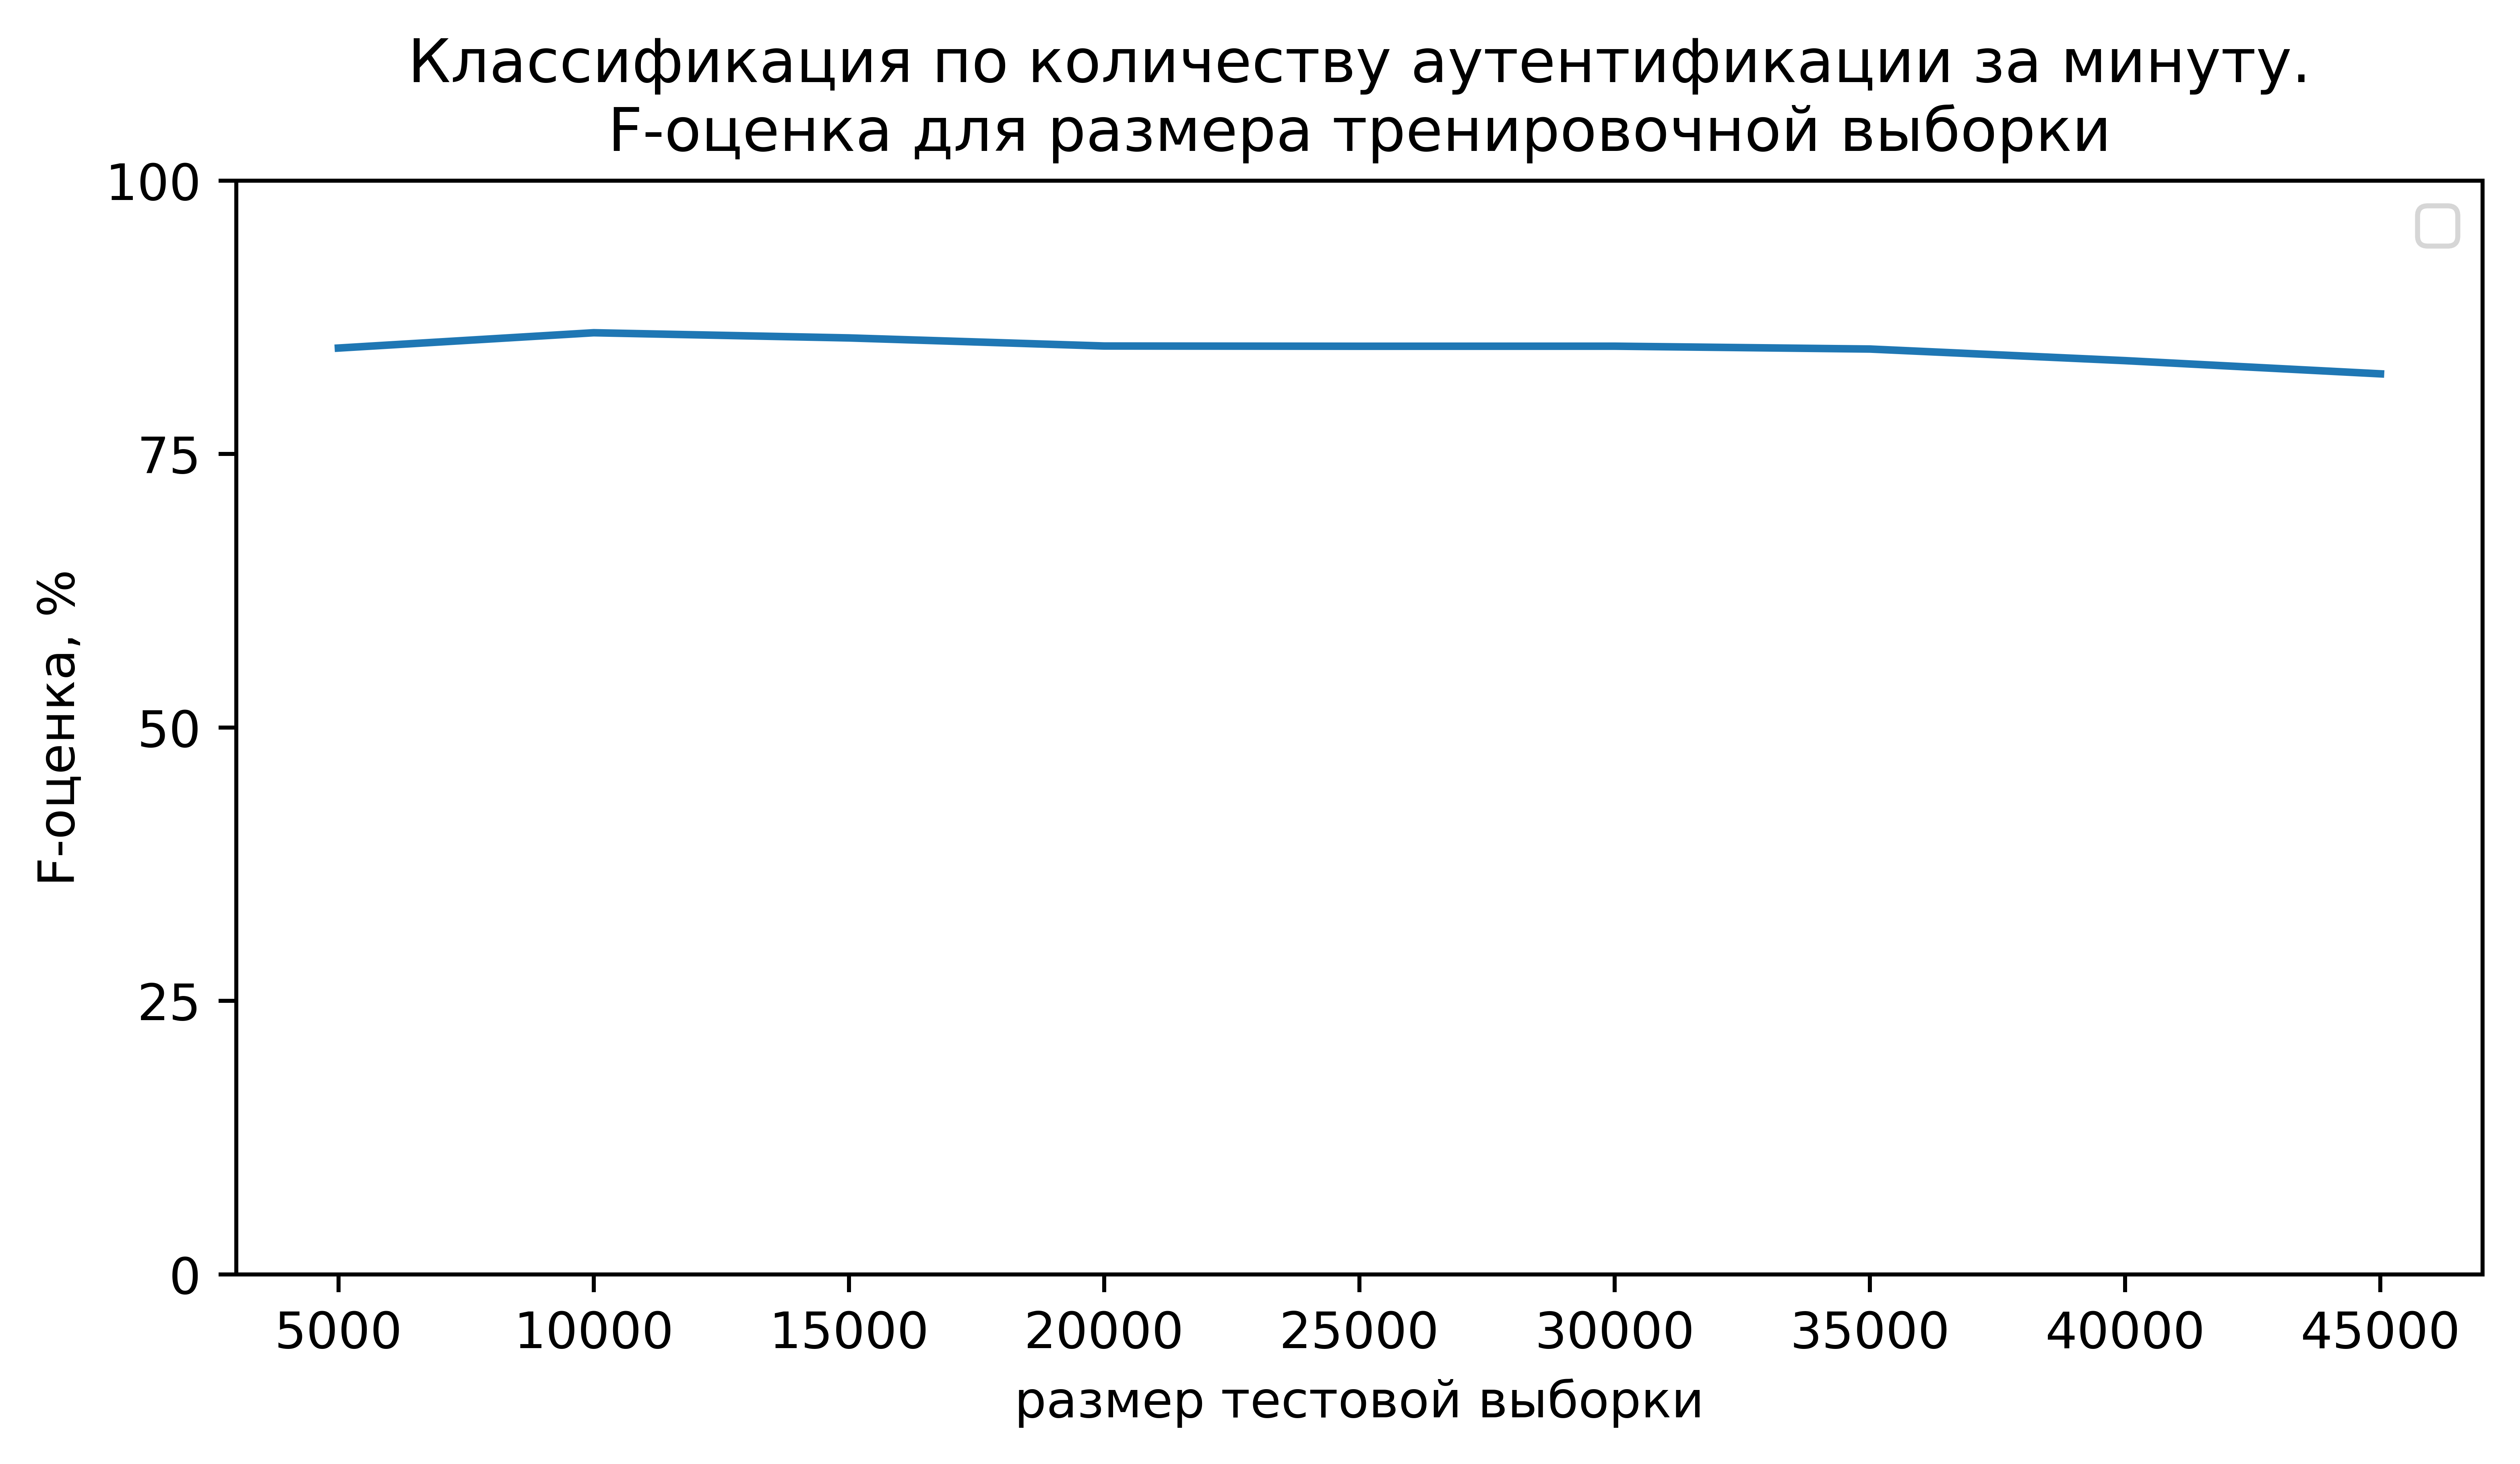

In [12]:
cv_scores, holdout_scores = [], []
split = np.arange(0.1, 1, 0.1)

for i in split:
    train_test_split_bound = int(test_logins.shape[0] * i)
    part_logins = test_logins[:train_test_split_bound]
    actual, predict = batch_predict_actual(clf, part_logins)
    holdout_scores.append(f1_score(actual, predict))

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,100)
plt.yticks(np.linspace(0,100,5,endpoint=True))
plt.ylabel('F-оценка, %')
plt.xlabel('размер тестовой выборки')
plt.plot(split * test_logins.shape[0], np.multiply(holdout_scores, 100))
plt.title('Классификация по количеству аутентификации за минуту.\nF-оценка для размера тренировочной выборки')
plt.savefig(GRAPH_PATH + 'logins_svm_gcd_holdout.png', dpi=900)
plt.legend();